In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [2]:
'''
define image transforms, link two transforms together, 
1.) changes the image(color) to a tensor
2.) normalize image from range [0,1] to range [-1,1]
'''
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root=r'C:\Users\Alec\Documents\Data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=r'C:\Users\Alec\Documents\Data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imgshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

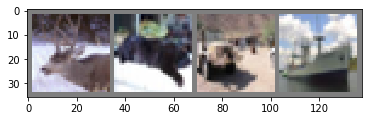

 deer   cat truck  ship


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
#batchsize is 4, which is we can show images in groups of 4

In [44]:
def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('bior1.1')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=1, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=1, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [28]:
maxnet = Net()
train_loss = []
run_loss = []
test_loss = []
max_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(maxnet.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(20):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = maxnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = maxnet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    max_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.761
[1,  2000] running loss: 0.365
[1,  3000] running loss: 0.235
[1,  4000] running loss: 0.171
[1,  5000] running loss: 0.133
[1,  6000] running loss: 0.110
[1,  7000] running loss: 0.092
[1,  8000] running loss: 0.079
[1,  9000] running loss: 0.069
[1, 10000] running loss: 0.062
[1, 11000] running loss: 0.056
[1, 12000] running loss: 0.050
Accuracy of the network on the 12000 test images: 37 %
Epoch 1, Training Loss:  0.658, Testing Accuracy: 0.375
[2,  1000] running loss: 0.583
[2,  2000] running loss: 0.291
[2,  3000] running loss: 0.191
[2,  4000] running loss: 0.143
[2,  5000] running loss: 0.113
[2,  6000] running loss: 0.092
[2,  7000] running loss: 0.078
[2,  8000] running loss: 0.068
[2,  9000] running loss: 0.060
[2, 10000] running loss: 0.054
[2, 11000] running loss: 0.049
[2, 12000] running loss: 0.044
Accuracy of the network on the 12000 test images: 44 %
Epoch 2, Training Loss:  0.555, Testing Accuracy: 0.447
[3,  1000] running loss: 0.527
[3,

Text(0, 0.5, 'Error')

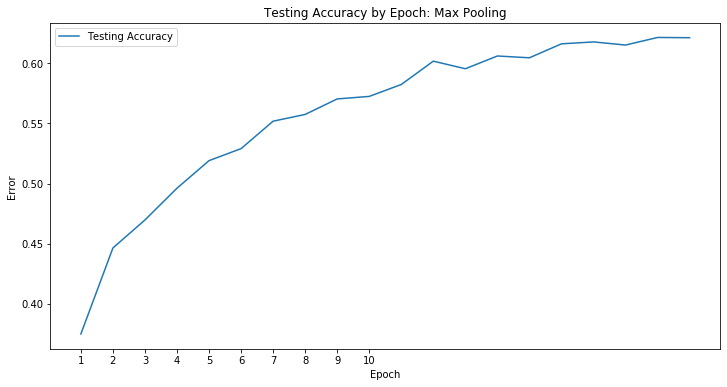

In [29]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,21, step=1), max_accuracy, label = 'Testing Accuracy')
plt.title('Testing Accuracy by Epoch: Max Pooling')
plt.xticks(np.arange(1,21, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [9]:
class MeanNet(nn.Module):
    def __init__(self):
        super(MeanNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.AvgPool2d(2,2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [10]:
meannet = MeanNet()
train_loss = []
run_loss = []
test_loss = []
mean_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(meannet.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = meannet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = meannet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    mean_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.763
[1,  2000] running loss: 0.371
[1,  3000] running loss: 0.236
[1,  4000] running loss: 0.172
[1,  5000] running loss: 0.134
[1,  6000] running loss: 0.107
[1,  7000] running loss: 0.092
[1,  8000] running loss: 0.079
[1,  9000] running loss: 0.069
[1, 10000] running loss: 0.062
[1, 11000] running loss: 0.055
[1, 12000] running loss: 0.050
Accuracy of the network on the 12000 test images: 37 %
Epoch 1, Training Loss:  0.658, Testing Accuracy: 0.373
[2,  1000] running loss: 0.586
[2,  2000] running loss: 0.294
[2,  3000] running loss: 0.189
[2,  4000] running loss: 0.144
[2,  5000] running loss: 0.115
[2,  6000] running loss: 0.094
[2,  7000] running loss: 0.080
[2,  8000] running loss: 0.070
[2,  9000] running loss: 0.062
[2, 10000] running loss: 0.056
[2, 11000] running loss: 0.050
[2, 12000] running loss: 0.046
Accuracy of the network on the 12000 test images: 42 %
Epoch 2, Training Loss:  0.565, Testing Accuracy: 0.423
[3,  1000] running loss: 0.544
[3,

Text(0, 0.5, 'Error')

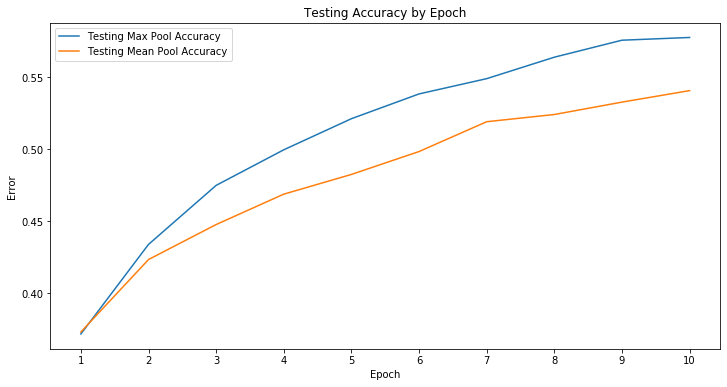

In [11]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_accuracy, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_accuracy, label = 'Testing Mean Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

## Wavelet Pooling

In [31]:
class HaarNet(nn.Module):
    def __init__(self):
        super(HaarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [32]:
Haarnet = HaarNet()
train_loss = []
run_loss = []
test_loss = []
haar_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(Haarnet.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(20):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Haarnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = Haarnet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    haar_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.748
[1,  2000] running loss: 0.351
[1,  3000] running loss: 0.223
[1,  4000] running loss: 0.162
[1,  5000] running loss: 0.128
[1,  6000] running loss: 0.103
[1,  7000] running loss: 0.087
[1,  8000] running loss: 0.075
[1,  9000] running loss: 0.066
[1, 10000] running loss: 0.058
[1, 11000] running loss: 0.052
[1, 12000] running loss: 0.048
Accuracy of the network on the 12000 test images: 39 %
Epoch 1, Training Loss:  0.627, Testing Accuracy: 0.394
[2,  1000] running loss: 0.564
[2,  2000] running loss: 0.280
[2,  3000] running loss: 0.185
[2,  4000] running loss: 0.135
[2,  5000] running loss: 0.110
[2,  6000] running loss: 0.090
[2,  7000] running loss: 0.076
[2,  8000] running loss: 0.066
[2,  9000] running loss: 0.058
[2, 10000] running loss: 0.052
[2, 11000] running loss: 0.047
[2, 12000] running loss: 0.043
Accuracy of the network on the 12000 test images: 45 %
Epoch 2, Training Loss:  0.535, Testing Accuracy: 0.452
[3,  1000] running loss: 0.509
[3,

Text(0, 0.5, 'Error')

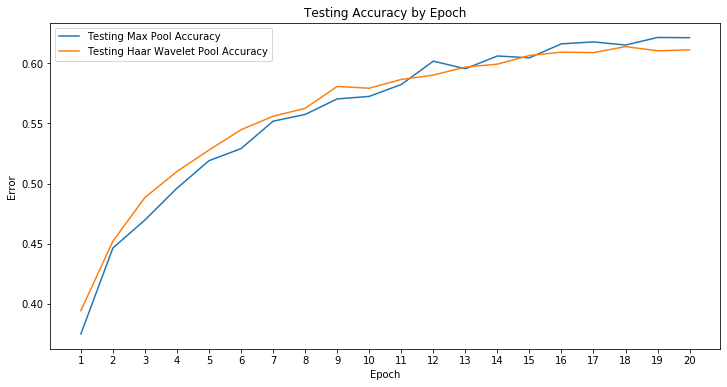

In [33]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,21, step=1), max_accuracy, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,21, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,21, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [35]:
class db2Net(nn.Module):
    def __init__(self):
        super(db2Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(10816, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [36]:
db2net = db2Net()
train_loss = []
run_loss = []
test_loss = []
db2_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(db2net.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(20):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = db2net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0

    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = db2net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    db2_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.748
[1,  2000] running loss: 0.352
[1,  3000] running loss: 0.224
[1,  4000] running loss: 0.165
[1,  5000] running loss: 0.130
[1,  6000] running loss: 0.106
[1,  7000] running loss: 0.089
[1,  8000] running loss: 0.076
[1,  9000] running loss: 0.067
[1, 10000] running loss: 0.060
[1, 11000] running loss: 0.053
[1, 12000] running loss: 0.049
Accuracy of the network on the 12000 test images: 37 %
Epoch 1, Training Loss:  0.637, Testing Accuracy: 0.378
[2,  1000] running loss: 0.572
[2,  2000] running loss: 0.285
[2,  3000] running loss: 0.187
[2,  4000] running loss: 0.140
[2,  5000] running loss: 0.111
[2,  6000] running loss: 0.093
[2,  7000] running loss: 0.079
[2,  8000] running loss: 0.067
[2,  9000] running loss: 0.060
[2, 10000] running loss: 0.054
[2, 11000] running loss: 0.048
[2, 12000] running loss: 0.044
Accuracy of the network on the 12000 test images: 44 %
Epoch 2, Training Loss:  0.549, Testing Accuracy: 0.443
[3,  1000] running loss: 0.516
[3,

Text(0, 0.5, 'Accuracy')

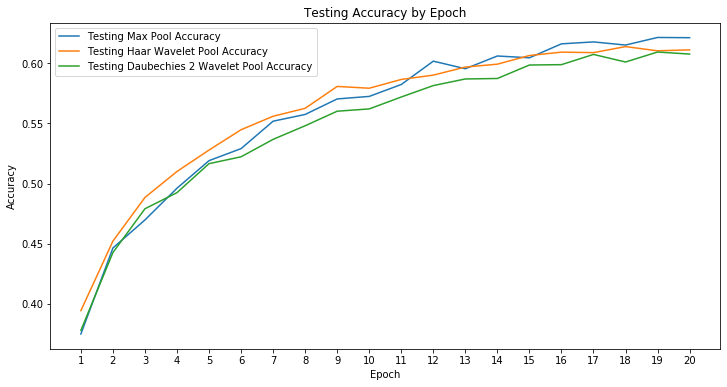

In [38]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,21, step=1), max_accuracy, label = 'Testing Max Pool Accuracy')

plt.plot(np.arange(1,21, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')

plt.plot(np.arange(1,21, step=1), db2_accuracy, label = 'Testing Daubechies 2 Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,21, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [40]:
class coif1Net(nn.Module):
    def __init__(self):
        super(coif1Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [42]:
coif1net = coif1Net()
train_loss = []
run_loss = []
test_loss = []
coif1_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(coif1net.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(20):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = coif1net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = coif1net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    coif1_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.755
[1,  2000] running loss: 0.357
[1,  3000] running loss: 0.229
[1,  4000] running loss: 0.169
[1,  5000] running loss: 0.131
[1,  6000] running loss: 0.107
[1,  7000] running loss: 0.091
[1,  8000] running loss: 0.077
[1,  9000] running loss: 0.068
[1, 10000] running loss: 0.061
[1, 11000] running loss: 0.054
[1, 12000] running loss: 0.049
Accuracy of the network on the 12000 test images: 38 %
Epoch 1, Training Loss:  0.645, Testing Accuracy: 0.387
[2,  1000] running loss: 0.576
[2,  2000] running loss: 0.287
[2,  3000] running loss: 0.187
[2,  4000] running loss: 0.139
[2,  5000] running loss: 0.112
[2,  6000] running loss: 0.089
[2,  7000] running loss: 0.078
[2,  8000] running loss: 0.068
[2,  9000] running loss: 0.060
[2, 10000] running loss: 0.054
[2, 11000] running loss: 0.048
[2, 12000] running loss: 0.044
Accuracy of the network on the 12000 test images: 44 %
Epoch 2, Training Loss:  0.547, Testing Accuracy: 0.442
[3,  1000] running loss: 0.516
[3,

Text(0, 0.5, 'Accuracy')

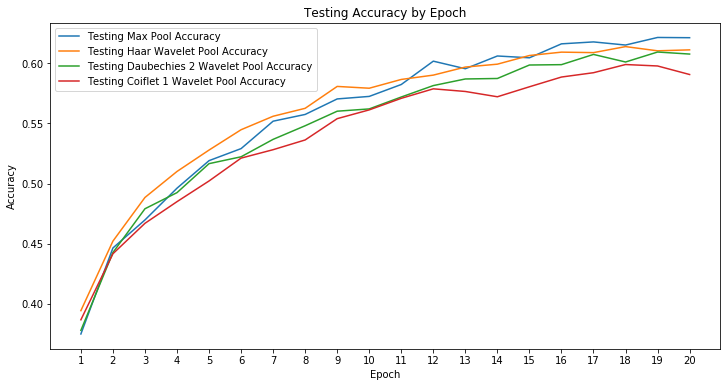

In [43]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,21, step=1), max_accuracy, label = 'Testing Max Pool Accuracy')

plt.plot(np.arange(1,21, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')

plt.plot(np.arange(1,21, step=1), db2_accuracy, label = 'Testing Daubechies 2 Wavelet Pool Accuracy')
plt.plot(np.arange(1,21, step=1), coif1_accuracy, label = 'Testing Coiflet 1 Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,21, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [47]:
class bior1Net(nn.Module):
    def __init__(self):
        super(bior1Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [49]:
bior1net = bior1Net()
train_loss = []
run_loss = []
test_loss = []
bior1_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(bior1net.parameters(), lr=0.0001, momentum=0.9)


for epoch in range(20):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = bior1net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    total = 0 
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = bior1net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    bior1_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.742
[1,  2000] running loss: 0.349
[1,  3000] running loss: 0.223
[1,  4000] running loss: 0.164
[1,  5000] running loss: 0.129
[1,  6000] running loss: 0.104
[1,  7000] running loss: 0.087
[1,  8000] running loss: 0.075
[1,  9000] running loss: 0.066
[1, 10000] running loss: 0.060
[1, 11000] running loss: 0.053
[1, 12000] running loss: 0.048
Accuracy of the network on the 12000 test images: 39 %
Epoch 1, Training Loss:  0.631, Testing Accuracy: 0.394
[2,  1000] running loss: 0.559
[2,  2000] running loss: 0.278
[2,  3000] running loss: 0.185
[2,  4000] running loss: 0.138
[2,  5000] running loss: 0.110
[2,  6000] running loss: 0.089
[2,  7000] running loss: 0.077
[2,  8000] running loss: 0.067
[2,  9000] running loss: 0.058
[2, 10000] running loss: 0.052
[2, 11000] running loss: 0.047
[2, 12000] running loss: 0.043
Accuracy of the network on the 12000 test images: 45 %
Epoch 2, Training Loss:  0.537, Testing Accuracy: 0.452
[3,  1000] running loss: 0.516
[3,

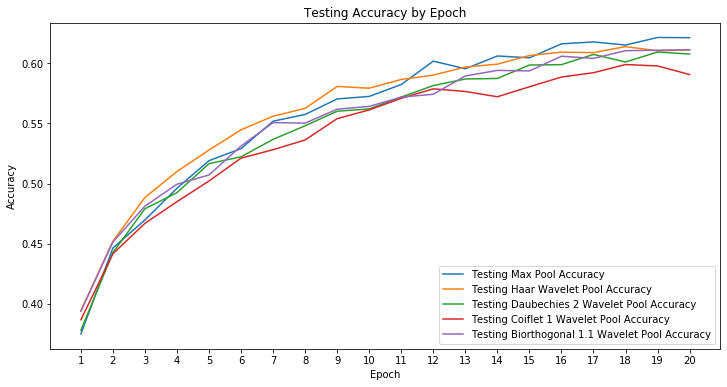

In [58]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,21, step=1), max_accuracy, label = 'Testing Max Pool Accuracy')

plt.plot(np.arange(1,21, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')

plt.plot(np.arange(1,21, step=1), db2_accuracy, label = 'Testing Daubechies 2 Wavelet Pool Accuracy')
plt.plot(np.arange(1,21, step=1), coif1_accuracy, label = 'Testing Coiflet 1 Wavelet Pool Accuracy')
plt.plot(np.arange(1,21, step=1), bior1_accuracy, label = 'Testing Biorthogonal 1.1 Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,21, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('CIFAR_Testing_Accuracy.png')

In [52]:
haar_accuracy

[0.3944,
 0.4522,
 0.4885,
 0.5101,
 0.5279,
 0.5448,
 0.556,
 0.5626,
 0.5808,
 0.5793,
 0.5866,
 0.5902,
 0.5969,
 0.5993,
 0.6065,
 0.6093,
 0.6089,
 0.6139,
 0.6104,
 0.6112]

In [53]:
max_accuracy

[0.375,
 0.4465,
 0.4698,
 0.4962,
 0.5191,
 0.5291,
 0.5519,
 0.5575,
 0.5704,
 0.5725,
 0.5824,
 0.6018,
 0.5955,
 0.6061,
 0.6046,
 0.6162,
 0.6178,
 0.6152,
 0.6215,
 0.6213]

In [55]:
db2_accuracy

[0.378,
 0.4427,
 0.4791,
 0.4925,
 0.5166,
 0.5223,
 0.5368,
 0.5481,
 0.5602,
 0.5621,
 0.572,
 0.5815,
 0.587,
 0.5874,
 0.5986,
 0.5989,
 0.6074,
 0.6011,
 0.6094,
 0.6077]

In [56]:
coif1_accuracy

[0.3868,
 0.4417,
 0.467,
 0.485,
 0.5022,
 0.5212,
 0.5282,
 0.5363,
 0.554,
 0.5613,
 0.5709,
 0.5788,
 0.5766,
 0.5722,
 0.5805,
 0.5886,
 0.5922,
 0.599,
 0.5978,
 0.5907]

In [57]:
bior1_accuracy

[0.3939,
 0.4515,
 0.4813,
 0.4995,
 0.5072,
 0.5313,
 0.5507,
 0.5503,
 0.5619,
 0.5642,
 0.5719,
 0.5743,
 0.5895,
 0.5941,
 0.5937,
 0.6059,
 0.6041,
 0.6105,
 0.6109,
 0.6113]